<a href="https://colab.research.google.com/github/IrisFDTD/AI-UNIZAR-course/blob/main/recurrent_networks/ai_unizar_course_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">*Introducción a la inteligencia artificial: redes neuronales avanzadas con Tensorflow-Keras*</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Sergio Gutiérrez Rodrigo (sergut@unizar.es)</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Licencia Creative Commons Atribución-NoComercial-CompartirIgual 4.0 Internacional</a>.

```
Sergio G Rodrigo
Departamento de Física Aplicada
Universidad de Zaragoza
Instituto de Nanociencia y Materiales de Aragón (INMA)
C/ Pedro Cerbuna, 12, 50009, Zaragoza, España
```






# **Advanced Neural Networks with TensorFlow-Keras**

---
# **Time Series Prediction with Recurrent Neural Networks (RNN)**
---


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Auxiliary functions

In [81]:
def plot_history(history):
    train_loss = history.history['loss']
    epochs = range(1, len(train_loss) + 1)

    # Extract the validation loss values
    val_loss = history.history['val_loss']

    # Plot the training loss and validation loss vs. epoch
    plt.rcParams.update({'font.size': 14})
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    pass


def plot_time_series(x,y_true,model,name_model='naive'):
    # Create the plot
    j=np.random.randint(x.shape[0])
    j=10
    n_steps=x.shape[1]
    time=list(range(1, n_steps + 1))

    if(name_model=='naive'):
      pred=x[j][n_steps-1][0]
    else:
      pred=model.predict(x[j].reshape(1, n_steps, 1))

    final_step=pred.shape[1]
    series=x[j]
    true=y_true[j][0:final_step]

    pred=np.squeeze(pred)
    true=np.squeeze(true)

    time_pred=np.arange(n_steps + 1,n_steps + 1+final_step)

    print("MSE=",tf.keras.losses.mean_squared_error([true],[pred]).numpy())

    plt.rcParams.update({'font.size': 14})
    plt.plot(time,series,label='data',marker='o',markersize=5)
    plt.plot(time_pred,true,'ro',label='target')
    plt.plot(time_pred,pred,'x',color='black',label=name_model)
    plt.xlabel(r'$t$ (time in a.u.)')
    plt.ylabel(r'$s(t)$')
    plt.grid(True)
    plt.legend(loc='upper left')
    # Show the plot
    plt.show()
    pass

# Generating data

$s(t)$ signal as a function of time = two sinusoidal waves + noise
---

$s(t)=\dfrac{1}{2}\sin[(t-\phi_1)(10\omega_1+10)]+\dfrac{1}{5}\sin[(t-\phi_2)(20\omega_2+20)]+noise$

where:
+ $\omega_1, \omega_2, \phi_1, \phi_2 \in [0,1]$
+ $\Delta t=\dfrac{1}{n_{steps}}=\frac{1}{60}$
+ $noise \in [-0.05,0.05]$

In [68]:
def generate_time_series(batch_size, n_steps):
  '''
  Return 4 vectors of random numbers of length batch_size
  '''
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
  return series[..., np.newaxis].astype(np.float32)

In [69]:
#generate new data with targets of length 10
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [70]:
print(X_train.shape,Y_train.shape)

(7000, 50, 1) (7000, 10)


## Plot example

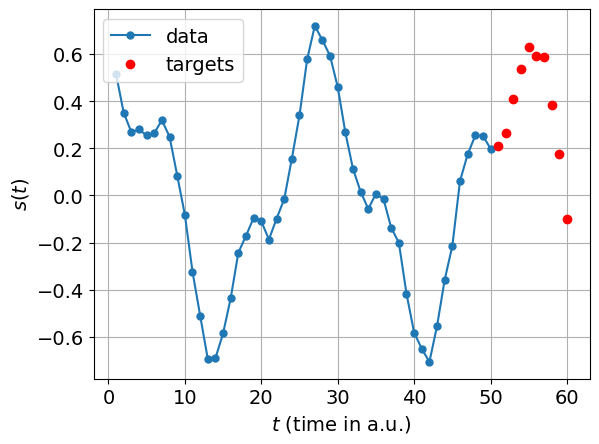

In [80]:
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 11)),Y_test[j],'ro',label='targets')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(loc='upper left')
# Show the plot
plt.show()

# **Predicting next time step of the time series**

## Baselines
We set the Baseline of our problem.


1.   Predicting the last value --> MSE 0.02
2.   Dense NN ('Adam', 20 Epochs)--> MSE 0.004



In [ ]:
#BASELINE1
#we predict the last value from each series
y_pred = X_test[:, -1]
print('MSE: ')
np.mean(tf.keras.losses.mean_squared_error(Y_test, y_pred))

In [ ]:
plot_time_series(X_test,Y_test,model=None,name_model='naive')

## Performance of RNN with a single neuron


### DNN

In [ ]:

model1 = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=[50, 1]),
tf.keras.layers.Dense(1)
])

model1.summary()
model1.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history1=model1.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))


In [ ]:
ypred=model1.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

In [ ]:
plot_history(history1)

In [ ]:
plot_time_series(X_test,Y_test,model=model1,name_model='FF neuron')

### Simple RNN
Now we will build a model with a single cell, the simplest there can be.
MSE--> 0.014
we beat the naive model, but not the dense network. Our model only has 3 parameters vs 51 in the other network. It is too simple.

In [ ]:
model2 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])])
#by deafault, it will only return the last output, hyperbolic tangent activation
#initial sate is set to 0

#We do not need to specify the length of the
#input sequences (unlike in the previous model), since a recurrent neural network can
#process any number of time steps (this is why we set the first input dimension to None)
model2.summary()

In [ ]:
model2.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history2=model2.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

In [ ]:
ypred=model2.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test[:,0], ypred))

In [ ]:
plot_history(history2)

In [ ]:
plot_time_series(X_test,Y_test,model=model2,name_model='Recursive cell')

### LSTM

In [ ]:
model3 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(1, input_shape=[None, 1])])
#by deafault, it will only return the last output, hyperbolic tangent activation
#initial sate is set to 0

#We do not need to specify the length of the
#input sequences (unlike in the previous model), since a recurrent neural network can
#process any number of time steps (this is why we set the first input dimension to None)
model3.summary()

In [ ]:
model3.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history3=model3.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

In [ ]:
ypred=model3.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

In [ ]:
plot_history(history3)

In [ ]:
plot_time_series(X_test,Y_test,model=model3,name_model='LSTM cell')

### GRU

In [ ]:
model4 = tf.keras.models.Sequential([
tf.keras.layers.GRU(1, input_shape=[None, 1])])
#by deafault, it will only return the last output, hyperbolic tangent activation
#initial sate is set to 0

#We do not need to specify the length of the
#input sequences (unlike in the previous model), since a recurrent neural network can
#process any number of time steps (this is why we set the first input dimension to None)
model4.summary()

In [ ]:
model4.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history4=model4.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

In [ ]:
ypred=model4.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

In [ ]:
plot_history(history4)

In [ ]:
plot_time_series(X_test,Y_test,model=model4,name_model='GRU cell')

## Performance of RNN with deep networks

###DNN

In [ ]:
model5 = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=[50, 1]),
tf.keras.layers.Dense(20),
tf.keras.layers.Dense(20),
tf.keras.layers.Dense(1)
])

model5.summary()

In [ ]:
model5.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history5=model5.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

In [ ]:
ypred=model5.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

In [ ]:
plot_history(history5)

In [ ]:
plot_time_series(X_test,Y_test,model=model5,name_model='DNN')

###Simple RNN
stack multiple layers of cells
MSE--> 0.0027 we beat the baseline!

In [ ]:
model6 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
tf.keras.layers.SimpleRNN(20, return_sequences=True),
tf.keras.layers.SimpleRNN(1)
])

model6.summary()

In [ ]:
model6.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history6=model6.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

In [ ]:
ypred=model6.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

In [ ]:
plot_history(history6)

In [ ]:
plot_time_series(X_test,Y_test,model=model6,name_model='Deep RNN')

Make sure to set return_sequences=True for all recurrent layers
(except the last one, if you only care about the last output). If you
don’t, they will output a 2D array (containing only the output of
the last time step) instead of a 3D array (containing outputs for all
time steps), and the next recurrent layer will complain that you are
not feeding it sequences in the expected 3D format.

The last layer is not ideal:


1.   Cannot choose activation function
2.   it must have a single unit because we want to forecast
a univariate time series, and this means we must have a single output value per
time step. However, having a single unit means that the hidden state is just a single
number. That’s really not much, and it’s probably not that useful; presumably, the
RNN will mostly use the hidden states of the other recurrent layers to carry over all
the information it needs from time step to time step, and it will not use the final layer’s
hidden state very much

We can use a Dense layer to solve this problems. MSE is similar, but it is more efficient.


In [ ]:
model7 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
tf.keras.layers.SimpleRNN(20),
tf.keras.layers.Dense(1)
])

model7.summary()

In [ ]:
model7.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history7=model7.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

In [ ]:
plot_history(history7)

In [ ]:
plot_time_series(X_test,Y_test,model=model7,name_model='Deep RNN (output = dense layer)')

### LSTM

In [ ]:
model8 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dense(1)
])

model8.summary()

In [ ]:
model8.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history8=model8.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

In [ ]:
plot_history(history8)

In [ ]:
plot_time_series(X_test,Y_test,model=model8,name_model='Deep LSTM')



### GRU

In [ ]:
model9 = tf.keras.models.Sequential([
tf.keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
tf.keras.layers.GRU(20),
tf.keras.layers.Dense(1)
])

model9.summary()

In [ ]:
model9.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history9=model9.fit(X_train, Y_train[:,0], epochs=20, validation_data=(X_valid, Y_valid[:,0]))

In [ ]:
plot_history(history9)

In [ ]:
plot_time_series(X_test,Y_test,model=model9,name_model='Deep LSTM')

# **Forecasting several time steps**
We have three options:


1.   Forecast the next step, add it to the timeseriries, and repeat
2.   Have targets of 10 timesteps
3.   Use a sequence to sequence network and train it to give all steps at once

We will try each one with the LSTM cell ,which is the one that has performed the best, to compare each of the methods



## Forecasting the next step iteratively


In [60]:
model= model9 #Choose a previous model

In [61]:
#predict
n_pred=10
j = np.random.randint(0, len(Y_test))

sequence=X_test[j].reshape(1,X_train.shape[1], 1)
for i in range (0,n_pred):
  pred=model.predict(sequence[:,i:,:]) #predict next timestep with previous 1000 steps
  sequence=np.concatenate((sequence, pred.reshape(1, 1, 1)), axis=1) #add it to the sequence
prediction=sequence[0,50:,:]
print(prediction)

1/1 [==============================] - 0s 19ms/step
[[-0.06654762]
 [-0.04275519]
 [-0.02163068]
 [-0.00793055]
 [-0.00085136]
 [ 0.00192294]
 [ 0.00244298]
 [ 0.00204372]
 [ 0.00143068]
 [ 0.00089902]]


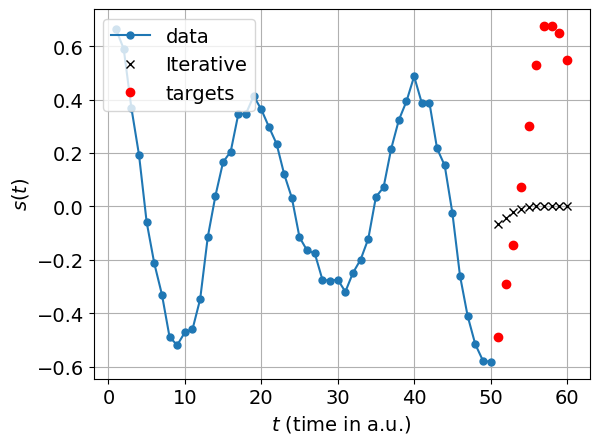

In [83]:
# Create the plot
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 11)),prediction,'x',color='black',label='Iterative')
plt.plot(list(range(n_steps + 1,n_steps + 11)),Y_test[j],'ro',label='targets')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(loc='upper left')
# Show the plot
plt.show()

## Sequence-to-Vector

In [ ]:
model10 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dense(10)
])
model10.summary()

In [ ]:
model10.compile(loss='mse',
          optimizer='adam',
          metrics='mae')

history10=model10.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

In [ ]:
plot_history(history10)

1/1 [==============================] - 0s 119ms/step
MSE= [0.00770131]


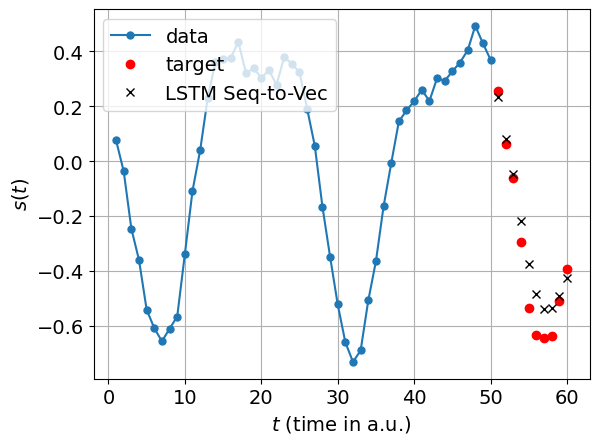

In [84]:
plot_time_series(X_test,Y_test,model=model10,name_model='LSTM Seq-to-Vec')

## Sequence-to-Sequence

instead of training
the model to forecast the next 10 values only at the very last time step, we can
train it to forecast the next 10 values at each and every time step. In other words, we
can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.



1.   loss will contain a term for the output of the RNN at
each and every time step
2.   more error gradients flowing through the model, and they won’t have to
flow only through time; they will also flow from the output of each time step. This
will both stabilize and speed up training.



## Generating data

In [74]:
#now, every target will contain n_steps vectors of dimension 10, each one shifted by 10 steps.
n_steps = 50
target_len=10

Y = np.empty((10000, n_steps, target_len)) # each target is a sequence of 10D vectors

for step_ahead in range(1, target_len + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]

Y_train_s2s = Y[:7000]
Y_valid_s2s = Y[7000:9000]
Y_test_s2s = Y[9000:]

It may be surprising that the targets will contain values that appear
in the inputs (there is a lot of overlap between X_train and
Y_train). Isn’t that cheating? Fortunately, not at all: at each time
step, the model only knows about past time steps, so it cannot look
ahead. It is said to be a causal model.

x_train shape= (7000, 50, 1)
y_train shape= (7000, 10)


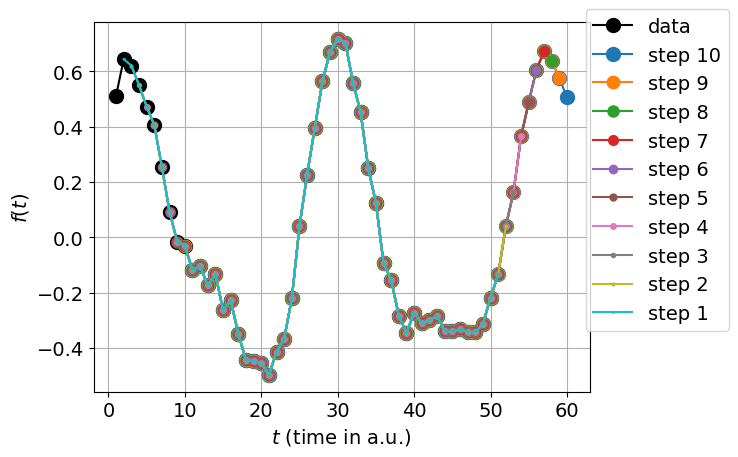

In [75]:
print("x_train shape=",X_train.shape)
print("y_train shape=",Y_train.shape)

# Create the plot
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],color='black',label='data',markersize=10,marker='o')
for step_ahead in range(target_len,0,-1):#range(1, target_len + 1):
  plt.plot(list(range(1+step_ahead, step_ahead+n_steps+1)),Y_test_s2s[j,:,step_ahead-1],markersize=int(step_ahead),marker='o',label="step "+str(step_ahead))
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.6))
plt.grid(True)
#plt.legend()

# Show the plot
plt.show()

### The model

+ $W_x=n_{inputs} \times n_{neurons}$
+ $W_y=n_{neurons} \times n_{neurons}$
+ $b= n_{neurons}$

In [ ]:
model11 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
tf.keras.layers.LSTM(20, return_sequences=True),
tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))
])

model11.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model11.compile(loss="mse", optimizer=optimizer, metrics=['mae'])

In [ ]:
history11=model11.fit(X_train, Y_train_s2s, epochs=20, validation_data=(X_valid, Y_valid_s2s))

In [ ]:
plot_history(history11)

1/1 [==============================] - 0s 72ms/step
(1000, 50, 1)
(1000, 50, 10)
(50, 10)
(1, 50, 10)
(50, 10)


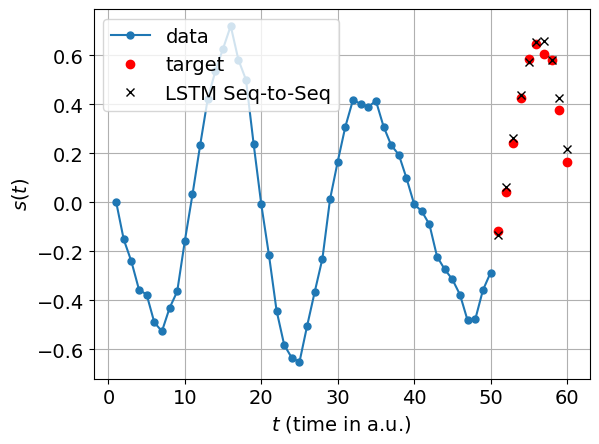

In [85]:
# Create the plot
# Y_test = samples x time_steps x target_points
# Each Y_test[j] = time_steps x target_points
# Note that Y_test[j,:,i] is the function shifted i+1 steps ahead
# Y_test[j][-1] are the last target_points values of all the shifted functions
# By construction is the result of the problem
target_len=10
j=np.random.randint(X_test.shape[0])
pred=model11.predict(X_test[j].reshape(1, 50, 1))
print(X_test.shape)
print(Y_test_s2s.shape)
print(Y_test_s2s[j].shape)
print(pred.shape)
print(pred[0].shape)
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + target_len+1)),Y_test_s2s[j][-1],'ro',label='target')
plt.plot(list(range(n_steps + 1,n_steps + target_len+1)),pred[0][-1],'x',color='black',label='LSTM Seq-to-Seq')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(loc='upper left')
# Show the plot
plt.show()
